# Lab 7: Confirmatory Data Analysis: AB Testing

## Setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## EDA

In [3]:
df_hob = pd.read_csv('/content/drive/My Drive/CEE322/Lab7/Hoboken.csv', header=0)
df_hob

,Y,D,Income,Lawn,Members,Owned
0,278.958436,False,50.275071,186.827382,2,1
1,293.875100,False,65.636335,275.556499,1,1
2,381.081020,False,68.871837,212.000238,3,0
3,356.563247,False,68.724770,172.341625,4,0
4,313.379817,False,58.128274,202.708432,1,0
...,...,...,...,...,...,...
195,235.250268,True,55.630055,163.331055,2,0
196,316.363701,True,52.935452,203.154557,4,1
197,299.513756,True,50.098517,184.672372,4,0
198,214.738584,True,54.704270,150.650043,3,1


In [4]:
df_hob[df_hob['D'] == False]

,Y,D,Income,Lawn,Members,Owned
0,278.958436,False,50.275071,186.827382,2,1
1,293.875100,False,65.636335,275.556499,1,1
2,381.081020,False,68.871837,212.000238,3,0
3,356.563247,False,68.724770,172.341625,4,0
4,313.379817,False,58.128274,202.708432,1,0
...,...,...,...,...,...,...
95,368.772033,False,55.009215,184.376731,6,1
96,355.663557,False,57.201757,175.547745,2,0
97,327.254882,False,65.105909,205.214542,3,0
98,266.911678,False,52.331308,155.880945,3,0


In [5]:
df_res = pd.read_csv('/content/drive/My Drive/CEE322/Lab7/Researcher.csv', header=0)
df_res

,Y,D,Members,Owned
0,264.271485,False,2,0
1,375.229551,False,3,1
2,256.447818,False,1,1
3,325.701571,False,5,0
4,257.237800,True,2,1
...,...,...,...,...
195,424.222022,True,6,1
196,432.054670,False,1,1
197,377.564539,True,1,0
198,465.095100,True,6,1


In [7]:
na_num = df_hob[df_hob.isnull().any(axis = 1)].shape[0]
na_percent = na_num / df_hob.shape[0]
print('There are ' + str(na_num) + ' rows having na (' + str(round(na_percent, 2)) + ' of sample size) in df_Ash')

There are 0 rows having na (0.0 of sample size) in df_Ash


In [8]:
na_num = df_res[df_res.isnull().any(axis = 1)].shape[0]
na_percent = na_num / df_res.shape[0]
print('There are ' + str(na_num) + ' rows having na (' + str(round(na_percent, 2)) + ' of sample size) in df_Ash')

There are 0 rows having na (0.0 of sample size) in df_Ash


In [6]:
def stepAIC_python(input_df, output_df, input = 'undefined', direction='both', scope=None):
    """Input df should have a separate input for each column. Output df should have the same index as input df, but with only one column (your output variable).
    
    Written by Siobhan Powell in 2020 to match R's stepAIC, with inspiration from: https://planspace.org/20150423-forward_selection_with_statsmodels/. 
    
    scope example input: scope = {'lower':['Var1', 'Var2'], 'upper':list(df.columns)}
    The lower set of variables will never be dropped, and the upper set of variables gives the bounds of what can be added.
    
    direction can be "both", "forward" or "backward". "Forward" only adds, starting from lower (or none). "Backward" only drops, starting from upper (or full). "Both" considers both, starting from upper (or full).
    """

    # Depending on direction and scope, update the initializations: 
    if scope is None: 
        never_drop = []
        if direction in ['both', 'backward']: # Default backward and both to start with the full set of inputs
            selected = list(input_df.columns)
            dropped_set = []
        else: # Default forward to start with an empty model
            selected = [] 
            dropped_set = list(input_df.columns)
    else:
        never_drop = scope['lower'] # If given a base set of inputs "lower" never to drop
        if direction in ['both', 'backward']: # Start with upper limit
            selected = scope['upper']
            dropped_set = []
        else:
            selected = scope['lower'] # Start with lower limit
            dropped_set = scope['upper']
            for i in selected:
                dropped_set.remove(i)
            
    # For uniform dealing with constants
    if 'const' in selected:
        selected.remove('const')
        
    # Score of the starting model
    X = input_df.loc[:, selected].copy(deep=True)
    X = sm.add_constant(X)
    current_score = sm.OLS(output_df, X).fit().aic
    best_new_score = np.copy(current_score)
    converged = False
    iters = 0

    while not converged and iters < 20: # Until cannot find a better model (by AIC)
        print(' ')
        print(' ')
        print('-------------------------- Step '+str(iters)+' ---------------------------')
        print(' ')
        scores_with_without_candidates = []
        if direction in ['both', 'backward']: # Check what happens if we remove each of the current inputs
            for candidate in selected: 
                if candidate not in never_drop: # Except for the ones we can never remove
                    test_selected = selected.copy()
                    test_selected.remove(candidate)
                    X = input_df.loc[:, test_selected].copy(deep=True)
                    X = sm.add_constant(X)
                    score = sm.OLS(output_df, X).fit().aic
                    scores_with_without_candidates.append((score, candidate, test_selected, '-'))
        if direction in ['both', 'forward']: # Check what happens if we add back a dropped or excluded input
            for candidate in dropped_set:
                test_selected = selected.copy()
                test_selected.append(candidate)
                X = input_df.loc[:, test_selected].copy(deep=True)
                X = sm.add_constant(X)
                score = sm.OLS(output_df, X).fit().aic
                scores_with_without_candidates.append((score, candidate, test_selected, '+'))
            
        scores_with_without_candidates.sort() # Sort the results to see what step gives the lowest AIC
            
        # Print an output similar to Rs with these results
        for val in scores_with_without_candidates:
            print(val[3] + val[1] + '. AIC : ', np.round(val[0], 2))
        best_new_score, best_candidate, new_selected, direction_considered = scores_with_without_candidates.pop(0)

        
        if current_score > best_new_score: # If that step will improve AIC, take the step
            print(' ')
            print('------ Result: '+direction_considered+best_candidate+'------')
            print(' ')
            # Keep track of dropped inputs
            if direction_considered == '-':
                dropped_set.append(best_candidate)            
            else:
                dropped_set.remove(best_candidate)
                
            # Update the model
            selected = new_selected.copy()
            print('------- New selected: ',selected)
            current_score = best_new_score
            X = input_df.loc[:, selected].copy(deep=True)
            X = sm.add_constant(X)
            model = sm.OLS(output_df, X).fit()

        else: # Otherwise, end
            converged=True
        iters += 1
        if iters == 20:
            print('Maxed out iterations')
            
    print(' ')
    print(' ')
    print('-------------------------- New Model ---------------------------')
    print(' ')
    # Print the final result
    X = input_df.loc[:, selected].copy(deep=True)
    X = sm.add_constant(X)
    model = sm.OLS(output_df, X).fit()
    print(model.summary())
    plt.hist(model.resid, bins=50)
    plt.xlabel('Residual of fitted line', fontsize = 14)
    plt.ylabel('Count', fontsize = 14)
    plt.title('Residual of fitted line of water consumption in ' + str(input), fontsize=14)
    plt.show()  
    
    return model

## Hob

In [10]:
df_hob.corr()

,Y,D,Income,Lawn,Members,Owned
Y,1.000000,-0.338847,0.643363,0.730350,0.427359,-0.072299
D,-0.338847,1.000000,-0.061540,-0.033648,-0.107124,0.120217
Income,0.643363,-0.061540,1.000000,0.656626,0.051380,-0.100082
Lawn,0.730350,-0.033648,0.656626,1.000000,-0.058015,-0.041131
Members,0.427359,-0.107124,0.051380,-0.058015,1.000000,0.033079
Owned,-0.072299,0.120217,-0.100082,-0.041131,0.033079,1.000000


In [11]:
df_hob.describe()

,Y,Income,Lawn,Members,Owned
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,319.280897,61.271090,203.706862,3.040000,0.470000
std,71.238440,11.091918,54.177693,1.590929,0.500352
min,175.820264,50.043810,73.374152,1.000000,0.000000
25%,269.572904,53.476266,168.729900,2.000000,0.000000
50%,311.222477,57.672374,197.625741,3.000000,0.000000
75%,357.809392,65.449906,233.217969,4.000000,1.000000
max,583.909945,112.569451,414.123731,6.000000,1.000000


### Average

In [12]:
df_hob[df_hob['D'] == False].describe()

,Y,Income,Lawn,Members,Owned
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,343.359377,61.951978,205.525265,3.210000,0.410000
std,72.404310,12.370755,54.283576,1.616175,0.494311
min,175.820264,50.043810,115.386633,1.000000,0.000000
25%,292.660545,53.632191,171.813883,2.000000,0.000000
50%,334.075420,56.943835,197.717928,3.000000,0.000000
75%,378.032404,66.293748,232.132978,4.000000,1.000000
max,583.909945,112.569451,414.123731,6.000000,1.000000


In [13]:
df_hob[df_hob['D'] == True].describe()

,Y,Income,Lawn,Members,Owned
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,295.202418,60.590201,201.888459,2.870000,0.530000
std,61.542256,9.660841,54.283580,1.554758,0.501614
min,178.522642,50.098517,73.374152,1.000000,0.000000
25%,249.354948,53.298399,165.652755,1.750000,0.000000
50%,292.684996,57.977313,197.625741,3.000000,1.000000
75%,335.171059,64.848686,234.699570,4.000000,1.000000
max,450.295274,93.651147,328.831076,6.000000,1.000000


In [14]:
df_hob[df_hob['D'] == False]['Y'].mean() - df_hob[df_hob['D'] == True]['Y'].mean()

48.15695900377233

### Regression

In [15]:
df_hob_dummy = pd.get_dummies(df_hob, columns=['D'])
df_hob_dummy.head()

,Y,Income,Lawn,Members,Owned,D_False,D_True
0,278.958436,50.275071,186.827382,2,1,1,0
1,293.875100,65.636335,275.556499,1,1,1,0
2,381.081020,68.871837,212.000238,3,0,1,0
3,356.563247,68.724770,172.341625,4,0,1,0
4,313.379817,58.128274,202.708432,1,0,1,0


In [16]:
df_hob_dummy.drop(columns=['D_False'], inplace = True)

In [17]:
Y = df_hob_dummy['Y']
X = df_hob_dummy.loc[:, ['Income', 'Lawn', 'Members', 'Owned', 'D_True']]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     216.5
Date:                Sat, 07 Nov 2020   Prob (F-statistic):           2.48e-77
Time:                        06:39:36   Log-Likelihood:                -948.10
No. Observations:                 200   AIC:                             1908.
Df Residuals:                     194   BIC:                             1928.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.7504     12.321      2.983      0.0

In [18]:
model = stepAIC_python(input_df = X, output_df = Y)

TypeError: ignored

### Income

In [30]:
df_hob_lincome = df_hob_dummy[df_hob_dummy['Income'] < 61.3]
df_hob_lincome

,Y,Income,Lawn,Members,Owned,D_True
0,278.958436,50.275071,186.827382,2,1,0
4,313.379817,58.128274,202.708432,1,0,0
5,322.393837,55.250037,192.630462,3,0,0
6,308.746686,50.786556,201.807771,2,0,0
7,329.263811,56.216763,127.383957,4,0,0
...,...,...,...,...,...,...
195,235.250268,55.630055,163.331055,2,0,1
196,316.363701,52.935452,203.154557,4,1,1
197,299.513756,50.098517,184.672372,4,0,1
198,214.738584,54.704270,150.650043,3,1,1


In [29]:
df_hob_hincome = df_hob_dummy[df_hob_dummy['Income'] > 61.3]
df_hob_hincome

,Y,Income,Lawn,Members,Owned,D_True
1,293.875100,65.636335,275.556499,1,1,0
2,381.081020,68.871837,212.000238,3,0,0
3,356.563247,68.724770,172.341625,4,0,0
8,375.707688,75.807867,183.156351,3,0,0
16,311.048738,70.041839,178.989793,3,1,0
...,...,...,...,...,...,...
183,422.060128,90.100739,319.639516,3,0,1
184,342.923955,65.547171,260.529691,3,0,1
186,297.166800,72.471994,233.124296,1,0,1
191,353.093392,64.920654,247.563957,5,1,1


In [24]:
df_hob_lincome[df_hob_lincome['D_True'] == 0]['Y'].mean() - df_hob_lincome[df_hob_lincome['D_True'] == 1]['Y'].mean()

37.09640506518252

In [56]:
df_hob_hincome[df_hob_hincome['D_True'] == 1]['Lawn'].mean() - df_hob_hincome[df_hob_hincome['D_True'] == 0]['Lawn'].mean()

-12.893432298312263

In [62]:
df_hob_hincome[df_hob_hincome['D_True'] == 1]['Members'].mean()

2.8857142857142857

In [41]:
df_hob_hincome['Lawn'].mean() - df_hob_lincome['Lawn'].mean()

50.189339959867425

In [26]:
def fit_hob(df, input):
  Y = df['Y']
  X = df.loc[:, ['Income', 'Lawn', 'Members', 'Owned', 'D_True']]
  X = sm.add_constant(X)
  model = stepAIC_python(input_df = X, output_df = Y, input=input)

 
 
-------------------------- Step 0 ---------------------------
 
-Owned. AIC :  1211.35
-Income. AIC :  1214.76
-D_True. AIC :  1255.77
-Members. AIC :  1306.32
-Lawn. AIC :  1322.45
 
------ Result: -Owned------
 
------- New selected:  ['Income', 'Lawn', 'Members', 'D_True']
 
 
-------------------------- Step 1 ---------------------------
 
-Income. AIC :  1212.82
+Owned. AIC :  1213.23
-D_True. AIC :  1253.93
-Members. AIC :  1305.56
-Lawn. AIC :  1321.56
 
 
-------------------------- New Model ---------------------------
 
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     91.40
Date:                Sat, 07 Nov 2020   Prob (F-statistic):           9.22e-36
Time:                        06:43:09   Log-Likelihood:            

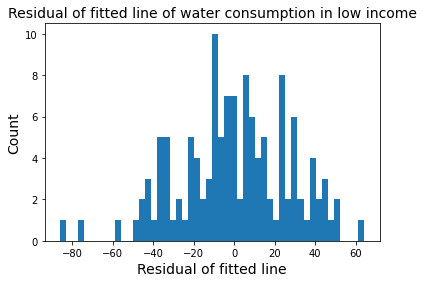

In [27]:
fit_hob(df_hob_lincome, input = 'low income')

 
 
-------------------------- Step 0 ---------------------------
 
-Owned. AIC :  700.06
-Income. AIC :  717.54
-D_True. AIC :  726.58
-Members. AIC :  758.71
-Lawn. AIC :  758.94
 
------ Result: -Owned------
 
------- New selected:  ['Income', 'Lawn', 'Members', 'D_True']
 
 
-------------------------- Step 1 ---------------------------
 
+Owned. AIC :  700.67
-Income. AIC :  716.65
-D_True. AIC :  727.17
-Members. AIC :  757.71
-Lawn. AIC :  758.22
 
 
-------------------------- New Model ---------------------------
 
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     121.9
Date:                Sat, 07 Nov 2020   Prob (F-statistic):           2.96e-30
Time:                        06:43:13   Log-Likelihood:                -345.0

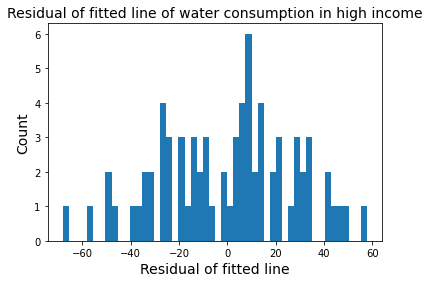

In [28]:
fit_hob(df_hob_hincome, 'high income')

### Lawn

In [48]:
df_hob_llawn = df_hob_dummy[df_hob_dummy['Lawn'] < 203.7]
df_hob_llawn

,Y,Income,Lawn,Members,Owned,D_True
0,278.958436,50.275071,186.827382,2,1,0
3,356.563247,68.724770,172.341625,4,0,0
4,313.379817,58.128274,202.708432,1,0,0
5,322.393837,55.250037,192.630462,3,0,0
6,308.746686,50.786556,201.807771,2,0,0
...,...,...,...,...,...,...
195,235.250268,55.630055,163.331055,2,0,1
196,316.363701,52.935452,203.154557,4,1,1
197,299.513756,50.098517,184.672372,4,0,1
198,214.738584,54.704270,150.650043,3,1,1


In [43]:
df_hob_hlawn = df_hob_dummy[df_hob_dummy['Lawn'] > 203.7]
df_hob_hlawn

,Y,Income,Lawn,Members,Owned,D_True
1,293.875100,65.636335,275.556499,1,1,0
2,381.081020,68.871837,212.000238,3,0,0
13,343.918596,59.031864,234.764160,3,0,0
19,423.853756,64.040979,231.677641,4,1,0
20,417.092828,79.400276,216.788635,4,0,0
...,...,...,...,...,...,...
187,292.758124,55.087391,268.295550,1,1,1
188,381.596777,57.928706,244.344408,6,1,1
189,321.018539,52.424664,221.552867,4,1,1
190,311.396215,56.846546,223.181335,1,0,1


In [44]:
df_hob_llawn[df_hob_llawn['D_True'] == 0]['Y'].mean() - df_hob_llawn[df_hob_llawn['D_True'] == 1]['Y'].mean()

45.83212644976936

In [52]:
df_hob_hlawn[df_hob_hlawn['D_True'] == 0]['Y'].mean()

393.95554966906025

In [45]:
df_hob_hlawn[df_hob_hlawn['D_True'] == 0]['Y'].mean() - df_hob_hlawn[df_hob_hlawn['D_True'] == 1]['Y'].mean()

58.471743394368275

 
 
-------------------------- Step 0 ---------------------------
 
-Owned. AIC :  1075.45
-Income. AIC :  1085.7
-D_True. AIC :  1113.14
-Lawn. AIC :  1131.88
-Members. AIC :  1154.96
 
------ Result: -Owned------
 
------- New selected:  ['Income', 'Lawn', 'Members', 'D_True']
 
 
-------------------------- Step 1 ---------------------------
 
+Owned. AIC :  1077.34
-Income. AIC :  1083.74
-D_True. AIC :  1111.22
-Lawn. AIC :  1130.74
-Members. AIC :  1152.97
 
 
-------------------------- New Model ---------------------------
 
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     62.61
Date:                Sat, 07 Nov 2020   Prob (F-statistic):           3.65e-27
Time:                        07:37:30   Log-Likelihood:             

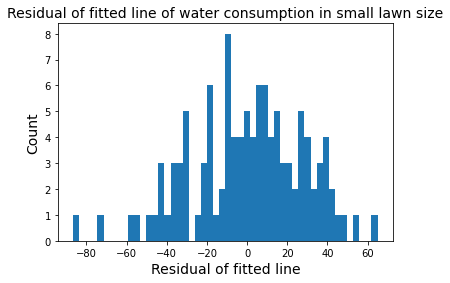

In [46]:
fit_hob(df_hob_llawn, 'small lawn size')

 
 
-------------------------- Step 0 ---------------------------
 
-Owned. AIC :  839.86
-Income. AIC :  852.43
-D_True. AIC :  870.32
-Lawn. AIC :  893.68
-Members. AIC :  913.61
 
------ Result: -Owned------
 
------- New selected:  ['Income', 'Lawn', 'Members', 'D_True']
 
 
-------------------------- Step 1 ---------------------------
 
+Owned. AIC :  840.66
-Income. AIC :  852.43
-D_True. AIC :  871.58
-Lawn. AIC :  892.14
-Members. AIC :  911.84
 
 
-------------------------- New Model ---------------------------
 
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     111.0
Date:                Sat, 07 Nov 2020   Prob (F-statistic):           1.73e-32
Time:                        07:37:33   Log-Likelihood:                -414.9

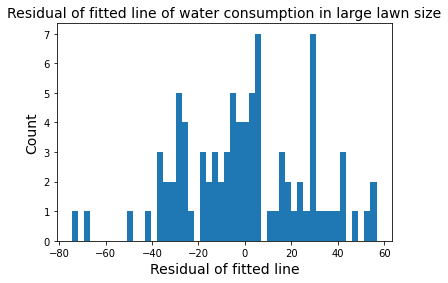

In [47]:
fit_hob(df_hob_hlawn, 'large lawn size')

### Member

In [63]:
df_hob_lmember = df_hob_dummy[df_hob_dummy['Members'] <= 3]
df_hob_lmember

,Y,Income,Lawn,Members,Owned,D_True
0,278.958436,50.275071,186.827382,2,1,0
1,293.875100,65.636335,275.556499,1,1,0
2,381.081020,68.871837,212.000238,3,0,0
4,313.379817,58.128274,202.708432,1,0,0
5,322.393837,55.250037,192.630462,3,0,0
...,...,...,...,...,...,...
190,311.396215,56.846546,223.181335,1,0,1
192,247.727165,53.596982,154.264625,2,1,1
193,266.804812,51.813351,158.300217,2,0,1
195,235.250268,55.630055,163.331055,2,0,1


In [64]:
df_hob_hmember = df_hob_dummy[df_hob_dummy['Members'] > 3]
df_hob_hmember

,Y,Income,Lawn,Members,Owned,D_True
3,356.563247,68.724770,172.341625,4,0,0
7,329.263811,56.216763,127.383957,4,0,0
9,339.681833,50.735909,154.861001,4,1,0
11,384.240269,59.647823,195.574590,4,1,0
12,334.329564,56.049371,145.449021,6,1,0
...,...,...,...,...,...,...
191,353.093392,64.920654,247.563957,5,1,1
194,292.611869,63.343908,162.315528,4,0,1
196,316.363701,52.935452,203.154557,4,1,1
197,299.513756,50.098517,184.672372,4,0,1


 
 
-------------------------- Step 0 ---------------------------
 
-Owned. AIC :  1157.09
-Income. AIC :  1178.11
-Members. AIC :  1181.8
-D_True. AIC :  1192.15
-Lawn. AIC :  1255.79
 
------ Result: -Owned------
 
------- New selected:  ['Income', 'Lawn', 'Members', 'D_True']
 
 
-------------------------- Step 1 ---------------------------
 
+Owned. AIC :  1159.09
-Income. AIC :  1176.43
-Members. AIC :  1179.97
-D_True. AIC :  1190.41
-Lawn. AIC :  1253.79
 
 
-------------------------- New Model ---------------------------
 
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     119.0
Date:                Sat, 07 Nov 2020   Prob (F-statistic):           4.20e-40
Time:                        09:18:45   Log-Likelihood:             

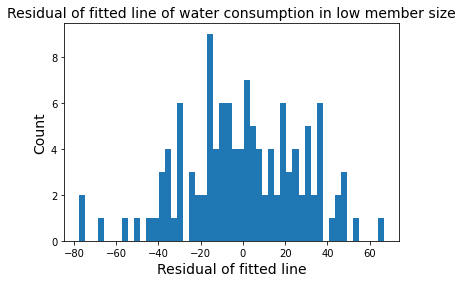

In [65]:
fit_hob(df_hob_lmember, 'low member size')

 
 
-------------------------- Step 0 ---------------------------
 
-Owned. AIC :  751.98
-Income. AIC :  758.66
-Members. AIC :  787.58
-D_True. AIC :  789.28
-Lawn. AIC :  828.53
 
------ Result: -Owned------
 
------- New selected:  ['Income', 'Lawn', 'Members', 'D_True']
 
 
-------------------------- Step 1 ---------------------------
 
+Owned. AIC :  753.57
-Income. AIC :  757.4
-Members. AIC :  785.62
-D_True. AIC :  789.42
-Lawn. AIC :  826.62
 
 
-------------------------- New Model ---------------------------
 
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     121.9
Date:                Sat, 07 Nov 2020   Prob (F-statistic):           9.04e-32
Time:                        09:18:48   Log-Likelihood:                -370.99

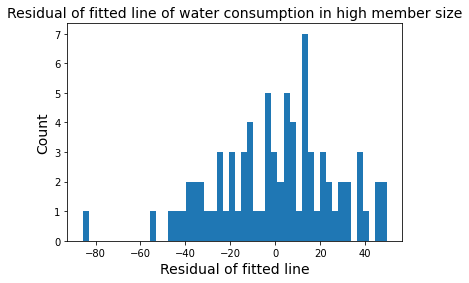

In [66]:
fit_hob(df_hob_hmember, 'high member size')

### Comparison

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0.5, 1.0, ' ATE comparison of the variables')

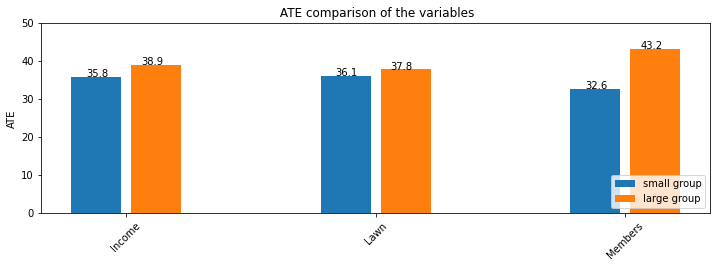

In [78]:
x = np.arange(len(train_performance))
width = 0.2

plt.figure(figsize = (12, 3.5))
plt.ylim = 1.3
train_performance = {'Income': [35.8], 'Lawn': [36.1], 'Members': [32.6]}
val_performance = {'Income': [38.9], 'Lawn': [37.8], 'Members': [43.2]}
train_acc = [v[0] for _, v in sorted(train_performance.items(), key = lambda x: x[0])]
val_acc = [v[0] for _, v in sorted(val_performance.items(), key = lambda x: x[0])]

plt.bar(x - 0.12, train_acc, width, label='small group')
plt.bar(x + 0.12, val_acc, width, label='large group')

  # Label Tops of Bars
for index, value in enumerate(train_acc):
  plt.text(index - 0.16, value + 0.015, str(value)[0:4])
for index, value in enumerate(val_acc):
  plt.text(index + 0.06, value + 0.015, str(value)[0:4])

  # Configure rest of plot to look nice
plt.xticks(ticks=x, labels=sorted(train_performance.keys()),
            rotation=45, fontsize = 10)
plt.axes().set_ylim(0,50)
plt.ylabel('ATE', fontsize = 10)
plt.legend(loc = 'lower right')
plt.title(' ATE comparison of the variables')

## Res

In [ ]:
df_res.corr()

### Average

In [8]:
df_res[df_res['D'] == False].describe()

,Y,Members,Owned
count,100.000000,100.000000,100.000000
mean,319.808451,2.960000,0.530000
std,56.651659,1.543445,0.501614
min,198.697873,1.000000,0.000000
25%,277.840286,1.000000,0.000000
50%,322.071653,3.000000,1.000000
75%,359.517403,4.000000,1.000000
max,471.972188,6.000000,1.000000


In [9]:
df_res[df_res['D'] == True].describe()

,Y,Members,Owned
count,100.000000,100.000000,100.00
mean,323.288283,3.270000,0.55
std,61.909011,1.556057,0.50
min,177.381157,1.000000,0.00
25%,286.608889,2.000000,0.00
50%,320.559123,3.000000,1.00
75%,360.314448,4.000000,1.00
max,474.520086,6.000000,1.00


In [14]:
df_res[df_res['D'] == False]['Members'].mean() - df_res[df_res['D'] == True]['Members'].mean()

-0.31000000000000005

### Regression

In [10]:
df_res_dummy = pd.get_dummies(df_res, columns=['D'])
df_res_dummy.head()

,Y,Members,Owned,D_False,D_True
0,264.271485,2,0,1,0
1,375.229551,3,1,1,0
2,256.447818,1,1,1,0
3,325.701571,5,0,1,0
4,257.237800,2,1,0,1


In [11]:
df_res_dummy.drop(columns=['D_False'], inplace = True)

In [12]:
Y = df_res_dummy['Y']
X = df_res_dummy.loc[:, ['Members', 'Owned', 'D_True']]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     14.27
Date:                Sat, 07 Nov 2020   Prob (F-statistic):           1.91e-08
Time:                        22:16:38   Log-Likelihood:                -1079.8
No. Observations:                 200   AIC:                             2168.
Df Residuals:                     196   BIC:                             2181.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        269.4699      9.994     26.965      0.0

 
 
-------------------------- Step 0 ---------------------------
 
-D_True. AIC :  2165.59
-Owned. AIC :  2165.98
-Members. AIC :  2204.54
 
------ Result: -D_True------
 
------- New selected:  ['Members', 'Owned']
 
 
-------------------------- Step 1 ---------------------------
 
-Owned. AIC :  2164.02
+D_True. AIC :  2167.54
-Members. AIC :  2202.7
 
------ Result: -Owned------
 
------- New selected:  ['Members']
 
 
-------------------------- Step 2 ---------------------------
 
+Owned. AIC :  2165.59
+D_True. AIC :  2165.98
-Members. AIC :  2201.04
 
 
-------------------------- New Model ---------------------------
 
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     42.65
Date:                Sat, 07 Nov 2020   Prob (F-st

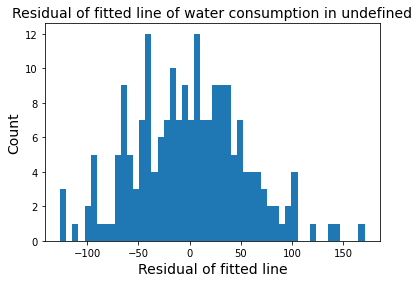

In [13]:
model = stepAIC_python(input_df = X, output_df = Y)